# Parse PATH monthly ridership PDF
```bash
papermill -p year $year [-p last_month $last_month] monthly.ipynb out/monthly-$year.ipynb
```

In [1]:
from utz import *
import json
from tabula import read_pdf

In [2]:
n = now()
cur_year = n.year
cur_month = n.month
cur_year, cur_month

(2024, 5)

Papermill parameters:

In [3]:
year = None
last_month = None
template = None

In [4]:
# Parameters
year = 2019


In [5]:
if year is None:
    year = cur_year

if last_month is None:
    if year == cur_year:
        last_month = 3
    else:
        last_month = 12

if template is None:
    if year >= 2023:
        template = '2023-PATH-Monthly-Ridership-Report.tabula-template.json'
    else:
        template = 'PATH-Monthly-Ridership-Report.json'

In [6]:
pdf = f'data/{year}-PATH-Monthly-Ridership-Report.pdf'
pdf

'data/2019-PATH-Monthly-Ridership-Report.pdf'

In [7]:
with open(f'templates/{template}', 'r') as f:
    rects = json.load(f)
rects

[{'y1': 121.284, 'x1': 70.016, 'y2': 245.247, 'x2': 568.926},
 {'y1': 261.316, 'x1': 71.546, 'y2': 407.469, 'x2': 569.691},
 {'y1': 482.459, 'x1': 70.781, 'y2': 603.36, 'x2': 568.161},
 {'y1': 620.96, 'x1': 70.781, 'y2': 761.757, 'x2': 569.691}]

In [8]:
area = [ [ r[k] for k in [ 'y1', 'x1', 'y2', 'x2' ] ] for r in rects ]
area

[[121.284, 70.016, 245.247, 568.926],
 [261.316, 71.546, 407.469, 569.691],
 [482.459, 70.781, 603.36, 568.161],
 [620.96, 70.781, 761.757, 569.691]]

In [9]:
tables = {
    month: read_pdf(
        pdf,
        pages=month,
        area=area,
        pandas_options={'header': None},
        stream=True,
    ) 
    for month in range(1, last_month + 1)
}

tables

Error importing jpype dependencies. Fallback to subprocess.


No module named 'jpype'


{1: [                    0          1        2       3       4       5
  0  Christopher Street    129,569    4,852   3,398   2,660   1,722
  1           9thStreet    125,073    4,311   4,198   3,435   2,007
  2          14thStreet    231,115    8,714   5,780   4,520   3,455
  3          23rdStreet    217,469    9,028   3,158   2,476   2,670
  4          33rdStreet    835,979   33,022  15,785  12,621  14,442
  5     UPTOWN SUBTOTAL  1,539,205   59,927  32,319  25,712  24,296
  6                 WTC  1,374,872   62,753   3,073   2,173  18,042
  7   NEW YORK SUBTOTAL  2,914,077  122,680  35,392  27,885  42,338,
                       0          1        2       3       4       5
  0               Newark    676,165   29,076   7,199   5,074   8,238
  1             Harrison    203,382    8,691   2,287   1,650   2,565
  2       Journal Square    626,190   25,066  11,442   8,337  10,349
  3         Grove Street    511,577   20,804   8,959   6,250   6,934
  4       Exchange Place    413,756   1

In [10]:
cols1 = [ 'station', 'total', 'avg weekday', 'avg sat', 'avg sun', 'avg holiday' ]
cols2 = [ 'station', 'avg daily', 'total weekday', 'total sat', 'total sun', 'total holiday' ]

In [11]:
for k, v in tables.items():
    n = len(v)
    msg = f'Pg {k}: {n} tables'
    if n == 4:
        print(msg)
    else:
        err(msg)
len(tables)

Pg 1: 4 tables
Pg 2: 4 tables
Pg 3: 4 tables
Pg 4: 4 tables
Pg 5: 4 tables
Pg 6: 4 tables
Pg 7: 4 tables
Pg 8: 4 tables
Pg 9: 4 tables
Pg 10: 4 tables
Pg 11: 4 tables
Pg 12: 4 tables


12

In [12]:
avgs = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[:2]
])
avgs['date'] = avgs.date.dt.date
avgs

0          1        2        3       4       5  \
0    Christopher Street    129,569    4,852    3,398   2,660   1,722   
1             9thStreet    125,073    4,311    4,198   3,435   2,007   
2            14thStreet    231,115    8,714    5,780   4,520   3,455   
3            23rdStreet    217,469    9,028    3,158   2,476   2,670   
4            33rdStreet    835,979   33,022   15,785  12,621  14,442   
..                  ...        ...      ...      ...     ...     ...   
4        Exchange Place    385,658   16,201    5,569   3,817   4,074   
5      Pavonia/ Newport    435,619   17,313    9,105   6,054   5,366   
6               Hoboken    654,813   26,599   12,868   8,163   3,949   
7   NEW JERSEY SUBTOTAL  3,535,587  142,049   69,877  46,901  38,560   
8         MONTHLY TOTAL  6,453,522  257,959  128,538  89,895  72,757   

          date  
0   2019-01-01  
1   2019-01-01  
2   2019-01-01  
3   2019-01-01  
4   2019-01-01  
..         ...  
4   2019-12-01  
5   2019-12-01  
6   2019-12-01  
7   2019-12-01  
8   2019-12-01  

[204 rows x 7 columns]

In [13]:
avgs.columns = cols1 + ['month']
avgs = avgs.assign(**{
    k: avgs[k].astype(str).str.replace(',', '').astype(int)
    for k in cols1[1:]
})
avgs

station    total  avg weekday  avg sat  avg sun  avg holiday  \
0    Christopher Street   129569         4852     3398     2660         1722   
1             9thStreet   125073         4311     4198     3435         2007   
2            14thStreet   231115         8714     5780     4520         3455   
3            23rdStreet   217469         9028     3158     2476         2670   
4            33rdStreet   835979        33022    15785    12621        14442   
..                  ...      ...          ...      ...      ...          ...   
4        Exchange Place   385658        16201     5569     3817         4074   
5      Pavonia/ Newport   435619        17313     9105     6054         5366   
6               Hoboken   654813        26599    12868     8163         3949   
7   NEW JERSEY SUBTOTAL  3535587       142049    69877    46901        38560   
8         MONTHLY TOTAL  6453522       257959   128538    89895        72757   

         month  
0   2019-01-01  
1   2019-01-01  
2   2019-01-01  
3   2019-01-01  
4   2019-01-01  
..         ...  
4   2019-12-01  
5   2019-12-01  
6   2019-12-01  
7   2019-12-01  
8   2019-12-01  

[204 rows x 7 columns]

In [14]:
avgs.isna().sum(axis=0)

station        0
total          0
avg weekday    0
avg sat        0
avg sun        0
avg holiday    0
month          0
dtype: int64

In [15]:
avgs.dtypes

station        object
total           int64
avg weekday     int64
avg sat         int64
avg sun         int64
avg holiday     int64
month          object
dtype: object

In [16]:
sums = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[2:]
])
sums['date'] = sums.date.dt.date
sums.columns = cols2 + ['month']
sums = sums.assign(**{
    k: sums[k].astype(str).str.replace(',', '').astype(int)
    for k in cols2[1:]
})
sums

station  avg daily  total weekday  total sat  total sun  \
0    Christopher Street       4180         101893      13591      10640   
1             9thStreet       4035          90525      16794      13740   
2            14thStreet       7455         183002      23121      18082   
3            23rdStreet       7015         189591      12633       9906   
4            33rdStreet      26967         693470      63139      50485   
..                  ...        ...            ...        ...        ...   
4        Exchange Place      12441         340224      22277      19083   
5      Pavonia/ Newport      14052         363564      36419      30270   
6               Hoboken      21123         558578      51472      40814   
7   NEW JERSEY SUBTOTAL     114051        2983014     279510     234503   
8         MONTHLY TOTAL     208178        5417136     514152     449477   

    total holiday       month  
0            3445  2019-01-01  
1            4014  2019-01-01  
2            6910  2019-01-01  
3            5339  2019-01-01  
4           28885  2019-01-01  
..            ...         ...  
4            4074  2019-12-01  
5            5366  2019-12-01  
6            3949  2019-12-01  
7           38560  2019-12-01  
8           72757  2019-12-01  

[204 rows x 7 columns]

In [17]:
sums.isna().sum(axis=0)

station          0
avg daily        0
total weekday    0
total sat        0
total sun        0
total holiday    0
month            0
dtype: int64

In [18]:
sums.dtypes

station          object
avg daily         int64
total weekday     int64
total sat         int64
total sun         int64
total holiday     int64
month            object
dtype: object

In [19]:
df = sxs(
    avgs.set_index(['month', 'station']),
    sums.set_index(['month', 'station']),
)
df = df[[cols2[1]] + cols1[2:] + [cols1[1]] + cols2[2:]]
df

avg daily  avg weekday  avg sat  avg sun  \
month      station                                                         
2019-01-01 Christopher Street        4180         4852     3398     2660   
           9thStreet                 4035         4311     4198     3435   
           14thStreet                7455         8714     5780     4520   
           23rdStreet                7015         9028     3158     2476   
           33rdStreet               26967        33022    15785    12621   
...                                   ...          ...      ...      ...   
2019-12-01 Exchange Place           12441        16201     5569     3817   
           Pavonia/ Newport         14052        17313     9105     6054   
           Hoboken                  21123        26599    12868     8163   
           NEW JERSEY SUBTOTAL     114051       142049    69877    46901   
           MONTHLY TOTAL           208178       257959   128538    89895   

                                avg holiday    total  total weekday  \
month      station                                                    
2019-01-01 Christopher Street          1722   129569         101893   
           9thStreet                   2007   125073          90525   
           14thStreet                  3455   231115         183002   
           23rdStreet                  2670   217469         189591   
           33rdStreet                 14442   835979         693470   
...                                     ...      ...            ...   
2019-12-01 Exchange Place              4074   385658         340224   
           Pavonia/ Newport            5366   435619         363564   
           Hoboken                     3949   654813         558578   
           NEW JERSEY SUBTOTAL        38560  3535587        2983014   
           MONTHLY TOTAL              72757  6453522        5417136   

                                total sat  total sun  total holiday  
month      station                                                   
2019-01-01 Christopher Street       13591      10640           3445  
           9thStreet                16794      13740           4014  
           14thStreet               23121      18082           6910  
           23rdStreet               12633       9906           5339  
           33rdStreet               63139      50485          28885  
...                                   ...        ...            ...  
2019-12-01 Exchange Place           22277      19083           4074  
           Pavonia/ Newport         36419      30270           5366  
           Hoboken                  51472      40814           3949  
           NEW JERSEY SUBTOTAL     279510     234503          38560  
           MONTHLY TOTAL           514152     449477          72757  

[204 rows x 10 columns]

In [20]:
path = f'data/{year}.pqt'
df.to_parquet(path)

In [21]:
import plotly.express as px
from IPython.display import Image

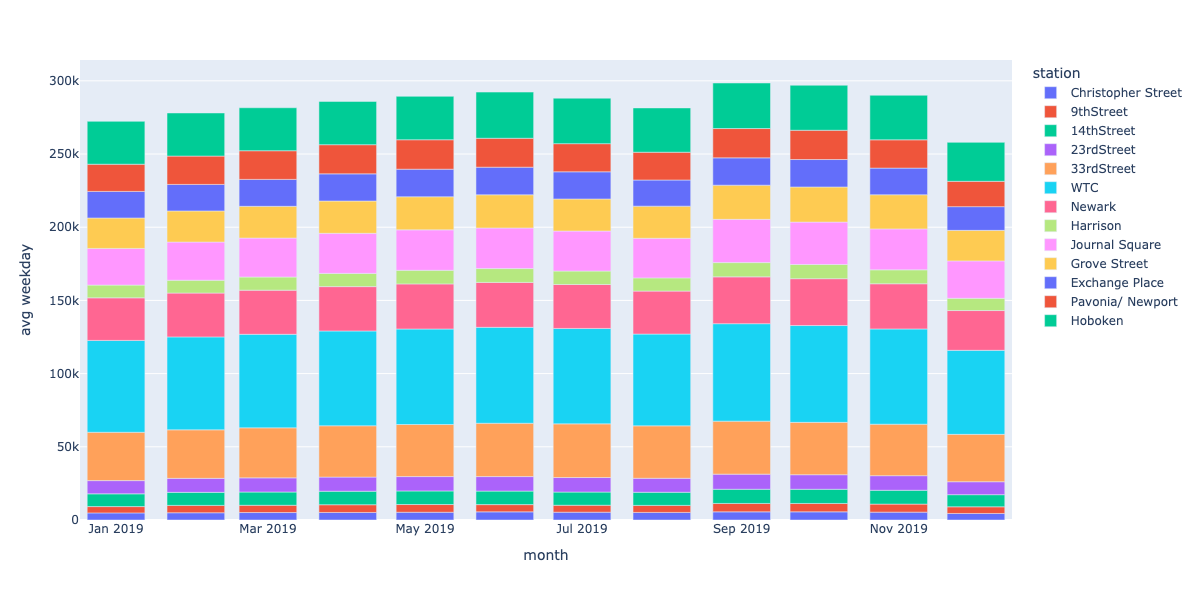

In [22]:
fig = px.bar(
    avgs[~avgs.station.str.contains('TOTAL')],
    x='month', y='avg weekday', color='station',
)
Image(fig.to_image(width=1200, height=600))